In [9]:
import numpy as np
import pandas as pd
import csv
from time import time

# plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
data_17_08 = pd.read_csv('../data/properati/properati-AR-2017-08-01-properties-sell.csv')
data_17_02 = pd.read_csv('../data/properati/properati-AR-2017-02-01-properties-sell.csv')
data_16_08 = pd.read_csv('../data/properati/properati-AR-2016-08-01-properties-sell.csv')
data_16_02 = pd.read_csv('../data/properati/properati-AR-2016-02-01-properties-sell.csv')
data_15_08 = pd.read_csv('../data/properati/properati-AR-2015-08-01-properties-sell.csv')
data_15_02 = pd.read_csv('../data/properati/properati-AR-2015-02-01-properties-sell.csv')
data_14_08 = pd.read_csv('../data/properati/properati-AR-2014-08-01-properties-sell.csv')
data_14_02 = pd.read_csv('../data/properati/properati-AR-2014-02-01-properties-sell.csv')
data_13_08 = pd.read_csv('../data/properati/properati-AR-2013-08-01-properties-sell.csv')

data_frames16_17 = [data_17_08, data_17_02, data_16_08, data_16_02]
train16_17 = pd.concat(data_frames16_17)

#Nos quedamos con las zonas de Capital Federal y GBA
train16_17 = train16_17.loc[(train16_17.state_name=='Capital Federal') | (train16_17.state_name.str.contains('G.B.A'))]

#Los dataframe del 2013, 2014, 2015 no tienen la columna state_name, todas las propiedades son de CABA y GBA
data_frames13_15 = [data_15_08,data_15_02,data_14_08,data_14_02,data_13_08]
train13_15 = pd.concat(data_frames13_15)

train13_15.rename(columns={'surface_in_m2':'surface_total_in_m2'}, inplace=True)

data_frames = [train16_17,train13_15]
train = pd.concat(data_frames)

In [3]:
train = train.loc[(train.property_type != 'store')]

In [4]:
train['created_on'] = pd.to_datetime(train['created_on'])
train = train.drop('image_thumbnail', axis=1)
train = train.drop('operation', axis=1)
train = train.drop('properati_url', axis=1)
train = train.drop('description', axis=1)
train = train.drop('place_with_parent_names', axis=1)
train = train.drop('title', axis=1)
train = train.drop('place_name', axis=1)
train = train.drop('state_name', axis=1)
train = train.drop('property_type', axis=1)
train = train.drop('lat-lon', axis=1)
train = train.drop('id', axis=1)
train = train.drop('country_name', axis=1)
train = train.drop('extra', axis=1)
train = train.drop('price_aprox_local_currency', axis=1)
train = train.drop('price_per_m2', axis=1)
train = train.drop('currency', axis=1)
train = train.drop('created_on', axis=1)
train = train.drop('geonames_id', axis=1)
train = train.drop('lat', axis=1)
train = train.drop('lon', axis=1)
train = train.drop('price', axis=1)

In [5]:
train['expenses'] = pd.to_numeric(train['expenses'], errors='coerce')
train['price_usd_per_m2'] = pd.to_numeric(train['price_usd_per_m2'], errors='coerce')
train['surface_covered_in_m2'] = pd.to_numeric(train['surface_covered_in_m2'], errors='coerce')
train['surface_total_in_m2'] = pd.to_numeric(train['surface_total_in_m2'], errors='coerce')
train['floor'] = pd.to_numeric(train['floor'], errors='coerce')
train['rooms'] = pd.to_numeric(train['rooms'], errors='coerce')

train[['price_usd_per_m2', 'rooms','surface_covered_in_m2','surface_total_in_m2']] \
= train[['price_usd_per_m2', 'rooms','surface_covered_in_m2','surface_total_in_m2']].fillna(value=0)
train[['expenses']] = train[['expenses']].fillna(value=0)
train[['floor']] = train[['floor']].fillna(value=0)
train[['price_aprox_usd']] = train[['price_aprox_usd']].fillna(value=0)

#Elimino las filas que no indican el precio (o indican el precio pero ningun otro feature)
train=train.loc[train['price_aprox_usd'] > 0]
train=train.loc[(train['expenses'] > 0) | (train['floor'] > 0) | (train['price_usd_per_m2'] > 0) | (train['rooms'] > 0) \
            | (train['surface_total_in_m2'] > 0)]

In [6]:
train.head(1)

,expenses,floor,price_aprox_usd,price_usd_per_m2,rooms,surface_covered_in_m2,surface_total_in_m2
0,0.0,0.0,120000.0,360.36036,0.0,93.0,333.0


In [7]:
train_label = []
train_data = []

train_label = train.iloc[:, 2]
train_data = train.iloc[:, train.columns != 'price_aprox_usd']

In [8]:
#-----------------------------------------------------------------
# Modelo Random Forest Regressor
#-----------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor

In [10]:
params = [ {'n_estimators': [50, 100, 150]},]

modeloRFR = RandomForestRegressor(random_state=0, n_jobs=-1)
grid = GridSearchCV(modeloRFR, params, n_jobs=-1)
grid.fit(train_data, train_label)

acc = grid.score(train_data, train_label)
print("[INFO] grid search accuracy: {:.2f}%".format(acc * 100))
print("[INFO] grid search best parameters: {}".format(grid.best_params_))

[INFO] grid search accuracy: 84.54%
[INFO] grid search best parameters: {'n_estimators': 100}


In [9]:
modeloRFR=RandomForestRegressor(random_state=0, n_jobs=-1, n_estimators=100)

In [13]:
precision = cross_val_score(modeloRFR, X=train_data, y=train_label, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
print ("Mean squared error: {0:.5f}").format(-precision.mean())

Mean squared error: 27109081230.21318


In [10]:
train_data_aux = train_data.drop('surface_covered_in_m2', axis=1)
precision = cross_val_score(modeloRFR, X=train_data_aux, y=train_label, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
print ("Mean squared error: {0:.5f}").format(-precision.mean())

Mean squared error: 26150216057.42389


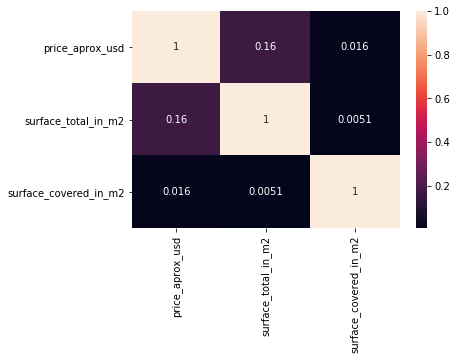

In [11]:
sns.heatmap(train[['price_aprox_usd','surface_total_in_m2','surface_covered_in_m2']].corr(),annot=True)

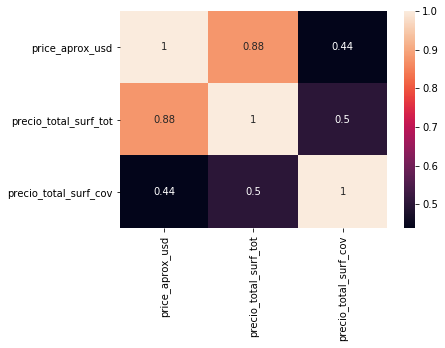

In [13]:
train_aux = train
train_aux['precio_total_surf_tot'] = train_aux['price_usd_per_m2'] * train_aux['surface_total_in_m2']
train_aux['precio_total_surf_cov'] = train_aux['price_usd_per_m2'] * train['surface_covered_in_m2']
sns.heatmap(train[['price_aprox_usd','precio_total_surf_tot','precio_total_surf_cov']].corr(),annot=True)
del train_aux

In [8]:
#surface_covered_in_m2 no es necesaria, surface_total_in_m2 es la relevante para el precio
train_data = train_data.drop('surface_covered_in_m2', axis=1)

In [15]:
train_data_aux = train_data.drop('floor', axis=1)
precision = cross_val_score(modeloRFR, X=train_data_aux, y=train_label, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
print ("Mean squared error: {0:.5f}").format(-precision.mean())

Mean squared error: 25830634026.45104


In [16]:
#floor no es necesaria, el piso no influye en el precio
#train_data = train_data.drop('floor', axis=1)
#Pero cuando lo subo a Kaggle, no da mejor resultado cuando no está floor

In [17]:
train_data_aux = train_data.drop('expenses', axis=1)
precision = cross_val_score(modeloRFR, X=train_data_aux, y=train_label, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
print ("Mean squared error: {0:.5f}").format(-precision.mean())

Mean squared error: 25852819748.88316


In [18]:
train_data_aux = train_data.drop('rooms', axis=1)
precision = cross_val_score(modeloRFR, X=train_data_aux, y=train_label, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
print ("Mean squared error: {0:.5f}").format(-precision.mean())

Mean squared error: 27393190249.79560


In [9]:
# cargamos el archivo de test
test  = pd.read_csv("../data/properati/properati_dataset_testing_noprice.csv")

test = test.drop('description', axis=1)
test = test.drop('place_with_parent_names', axis=1)
test = test.drop('place_name', axis=1)
test = test.drop('property_type', axis=1)
test = test.drop('lat-lon', axis=1)
test = test.drop('country_name', axis=1)
test = test.drop('operation', axis=1)
test = test.drop('created_on', axis=1)
test = test.drop('state_name', axis=1)
test = test.drop('lat', axis=1)
test = test.drop('lon', axis=1)
test = test.drop('surface_covered_in_m2', axis=1)
#test = test.drop('floor', axis=1)

test['expenses'] = pd.to_numeric(test['expenses'], errors='coerce')

test[['surface_total_in_m2','rooms','floor','expenses']] = \
test[['surface_total_in_m2','rooms','floor','expenses']].fillna(value=0)
test[['expenses']] = test[['expenses']].fillna(value=0)

In [30]:
modeloRFR.fit(train_data, train["price_aprox_usd"])

result = modeloRFR.predict(test)

In [10]:
def write_submission(test_data, prediction, file_output):
    
    archivo_entrada = open(test_data)
    entrada_csv = csv.reader(archivo_entrada)
    next(entrada_csv, None)  # skip the headers

    archivo_salida = open(file_output, 'w')
    submit_csv = csv.writer(archivo_salida)
    submit_csv.writerow(['id', 'price_usd'])

    for reg1, reg2  in zip(entrada_csv, prediction):
        linea = [reg1[0], round(reg2, 2)]
        submit_csv.writerow(linea)
    archivo_salida.close()

In [33]:
write_submission("../data/properati/properati_dataset_testing_noprice.csv", result, "../predicciones/RFR_n100_sinCovered.csv")

In [ ]:
del modeloRFR

In [38]:
#-----------------------------------------------------------------
# Modelo de Regresión Lineal
#-----------------------------------------------------------------
from sklearn.linear_model import LinearRegression

In [42]:
modeloLR=LinearRegression()

#modeloLR.fit(train_data,train_label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [44]:
precision = cross_val_score(modeloLR, X=train_data, y=train_label, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
print ("Mean squared error: {0:.5f}").format(-precision.mean())

Mean squared error: 204111411577.90945


In [ ]:
modeloLR.fit(train_data, train["price_aprox_usd"])

result = modeloLR.predict(test)

In [ ]:
write_submission("../data/properati/properati_dataset_testing_noprice.csv", result, "../predicciones/LR.csv")

In [ ]:
del modeloLR

In [9]:
#-----------------------------------------------------------------
# Modelo de Lasso
#-----------------------------------------------------------------
from sklearn.linear_model import Lasso

In [13]:
params = [ {'alpha': [0.5, 1.0]}]

modeloLasso = Lasso(random_state=0)
grid = GridSearchCV(modeloLasso, params, n_jobs=-1)
grid.fit(train_data, train_label)

acc = grid.score(train_data, train_label)
print("[INFO] grid search accuracy: {:.2f}%".format(acc * 100))
print("[INFO] grid search best parameters: {}".format(grid.best_params_))

[INFO] grid search accuracy: 13.92%
[INFO] grid search best parameters: {'alpha': 1.0}


In [60]:
#Mientras mas grande el alpha, para grid search es mejor, pero en la practica en porcentaje siempre da la misma precision
modeloLasso=Lasso(random_state=0, alpha=0.5)

#modeloLasso.fit(train_data,train_label)

In [61]:
precision = cross_val_score(modeloLasso, X=train_data, y=train_label, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
print ("Mean squared error: {0:.5f}").format(-precision.mean())

Mean squared error: 204110589404.69498


In [ ]:
modeloLasso.fit(train_data, train["price_aprox_usd"])

result = modeloLasso.predict(test)

In [ ]:
write_submission("../data/properati/properati_dataset_testing_noprice.csv", result, "../predicciones/Lasso.csv")

In [14]:
del modeloLasso

In [15]:
#-----------------------------------------------------------------
# Modelo Ridge
#-----------------------------------------------------------------
from sklearn.linear_model import Ridge

In [16]:
params = [ {'alpha': [0.1, 0.5, 1.0]}]

modeloRidge = Ridge(random_state=0)
grid = GridSearchCV(modeloRidge, params, n_jobs=-1)
grid.fit(train_data, train_label)

acc = grid.score(train_data, train_label)
print("[INFO] grid search accuracy: {:.2f}%".format(acc * 100))
print("[INFO] grid search best parameters: {}".format(grid.best_params_))

[INFO] grid search accuracy: 13.92%
[INFO] grid search best parameters: {'alpha': 0.1}


In [69]:
modeloRidge=Ridge(random_state=0, alpha=0.1)

#modeloRidge.fit(train_data,train_label)

In [70]:
precision = cross_val_score(modeloRidge, X=train_data, y=train_label, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
print ("Mean squared error: {0:.5f}").format(-precision.mean())

Mean squared error: 204111415689.90906


In [71]:
modeloRidge.fit(train_data, train["price_aprox_usd"])

result = modeloRidge.predict(test)

In [72]:
write_submission("../data/properati/properati_dataset_testing_noprice.csv", result, "../predicciones/Ridge.csv")

In [17]:
del modeloRidge

In [34]:
#-----------------------------------------------------------------
# Modelo BaggingRegressor
#-----------------------------------------------------------------
from sklearn.ensemble import BaggingRegressor

In [14]:
params = [ {'n_estimators': [50, 100, 150]}]

modeloBR = BaggingRegressor(random_state=0)
grid = GridSearchCV(modeloBR, params, n_jobs=-1)
grid.fit(train_data, train_label)

acc = grid.score(train_data, train_label)
print("[INFO] grid search accuracy: {:.2f}%".format(acc * 100))
print("[INFO] grid search best parameters: {}".format(grid.best_params_))

[INFO] grid search accuracy: 84.57%
[INFO] grid search best parameters: {'n_estimators': 100}


In [35]:
modeloBR=BaggingRegressor(n_estimators=100,random_state=0)

#modeloBR.fit(train_data,train_label)

In [36]:
precision = cross_val_score(modeloBR, X=train_data, y=train_label, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
print ("Mean squared error: {0:.5f}").format(-precision.mean())

Mean squared error: 26318271941.42833


In [37]:
modeloBR.fit(train_data, train["price_aprox_usd"])

result = modeloBR.predict(test)

In [38]:
write_submission("../data/properati/properati_dataset_testing_noprice.csv", result, "../predicciones/BR.csv")

In [39]:
del modeloBR

In [28]:
#-----------------------------------------------------------------
# Modelo ElasticNet
#-----------------------------------------------------------------
from sklearn.linear_model import ElasticNet

In [21]:
params = {'alpha':[0.1, 0.5, 1.0, 2.0], 'l1_ratio':[0.1, 0.5, 1.0, 2.0]}

modeloElasticNet = ElasticNet(random_state=0)
grid = GridSearchCV(modeloElasticNet, params, n_jobs=-1)
grid.fit(train_data, train_label)

acc = grid.score(train_data, train_label)
print("[INFO] grid search accuracy: {:.2f}%".format(acc * 100))
print("[INFO] grid search best parameters: {}".format(grid.best_params_))

[INFO] grid search accuracy: 7.01%
[INFO] grid search best parameters: {'alpha': 2.0, 'l1_ratio': 2.0}


In [29]:
#Con valores mas altos de alpha y l1_ratio no mejora la precisión
modeloElasticNet=ElasticNet(alpha=2.0,l1_ratio=2.0,random_state=0)

#modeloElasticNet.fit(train_data,train_label)

In [30]:
precision = cross_val_score(modeloElasticNet, X=train_data, y=train_label, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
print ("Mean squared error: {0:.5f}").format(-precision.mean())

Mean squared error: 150750135866.83401


In [31]:
modeloElasticNet.fit(train_data, train["price_aprox_usd"])

result = modeloElasticNet.predict(test)

In [32]:
write_submission("../data/properati/properati_dataset_testing_noprice.csv", result, "../predicciones/ElasticNet.csv")

In [33]:
del modeloElasticNet

In [23]:
#-----------------------------------------------------------------
# Modelo BayesianRidge
#-----------------------------------------------------------------
from sklearn.linear_model import BayesianRidge

In [25]:
params = {'alpha_1':[0.1, 0.5, 1.0, 2.0], 'alpha_2':[0.1, 0.5, 1.0, 2.0], 'lambda_1':[1e-06, 0.1, 1.0], 'lambda_2':[1e-06, 0.1, 1.0]}

modeloBRidge = BayesianRidge()
grid = GridSearchCV(modeloBRidge, params, n_jobs=-1)
grid.fit(train_data, train_label)

acc = grid.score(train_data, train_label)
print("[INFO] grid search accuracy: {:.2f}%".format(acc * 100))
print("[INFO] grid search best parameters: {}".format(grid.best_params_))

[INFO] grid search accuracy: 13.92%
[INFO] grid search best parameters: {'alpha_2': 0.1, 'lambda_1': 1e-06, 'lambda_2': 1.0, 'alpha_1': 2.0}


In [15]:
modeloBRidge=BayesianRidge(alpha_1=2.0,alpha_2=0.1,lambda_1=1e-06,lambda_2=1.0)

#modeloBRidge.fit(train_data,train_label)

In [16]:
precision = cross_val_score(modeloBRidge, X=train_data, y=train_label, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
print ("Mean squared error: {0:.5f}").format(-precision.mean())

Mean squared error: 204172338903.49078


In [17]:
modeloBRidge.fit(train_data, train["price_aprox_usd"])

result = modeloBRidge.predict(test)

In [18]:
write_submission("../data/properati/properati_dataset_testing_noprice.csv", result, "../predicciones/BRidge.csv")

In [26]:
del modeloBRidge

In [22]:
#-----------------------------------------------------------------
# Modelo AdaBoostRegressor
#-----------------------------------------------------------------
from sklearn.ensemble import AdaBoostRegressor

In [13]:
params = [{'n_estimators': [5, 10, 50]}]

modeloABR = AdaBoostRegressor(random_state=0)
grid = GridSearchCV(modeloABR, params, n_jobs=-1)
grid.fit(train_data, train_label)

acc = grid.score(train_data, train_label)
print("[INFO] grid search accuracy: {:.2f}%".format(acc * 100))
print("[INFO] grid search best parameters: {}".format(grid.best_params_))

[INFO] grid search accuracy: 28.22%
[INFO] grid search best parameters: {'n_estimators': 5}


In [23]:
modeloABR=AdaBoostRegressor(n_estimators=5,random_state=0) #Con n mas bajos no mejora la precisión

#modeloABR.fit(train_data,train_label)

In [24]:
precision = cross_val_score(modeloABR, X=train_data, y=train_label, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
print ("Mean squared error: {0:.5f}").format(-precision.mean())

Mean squared error: 91030806771.98343


In [25]:
modeloABR.fit(train_data, train["price_aprox_usd"])

result = modeloABR.predict(test)

In [26]:
write_submission("../data/properati/properati_dataset_testing_noprice.csv", result, "../predicciones/ABR.csv")

In [27]:
del modeloABR

In [17]:
#-----------------------------------------------------------------
# Modelo DecisionTreeRegressor
#-----------------------------------------------------------------
from sklearn.tree import DecisionTreeRegressor

In [18]:
modeloDecisionTreeR=DecisionTreeRegressor(random_state=0)

#modeloDecisionTreeR.fit(train_data,train_label)

In [19]:
precision = cross_val_score(modeloDecisionTreeR, X=train_data, y=train_label, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
print ("Mean squared error: {0:.5f}").format(-precision.mean())

Mean squared error: 25932647216.57199


In [23]:
modeloDecisionTreeR.fit(train_data, train["price_aprox_usd"])

result = modeloDecisionTreeR.predict(test)

In [24]:
write_submission("../data/properati/properati_dataset_testing_noprice.csv", result, "../predicciones/DecisionTreeR.csv")

In [25]:
del modeloDecisionTreeR

In [16]:
#-----------------------------------------------------------------
# Modelo KNN
#-----------------------------------------------------------------
from sklearn.neighbors import KNeighborsRegressor

In [12]:
params = [{'n_neighbors': [3, 5, 10]}]

modeloKNN = KNeighborsRegressor(n_jobs=-1)
grid = GridSearchCV(modeloKNN, params, n_jobs=-1)
grid.fit(train_data, train_label)

acc = grid.score(train_data, train_label)
print("[INFO] grid search accuracy: {:.2f}%".format(acc * 100))
print("[INFO] grid search best parameters: {}".format(grid.best_params_))

[INFO] grid search accuracy: 75.77%
[INFO] grid search best parameters: {'n_neighbors': 5}


In [17]:
modeloKNN=KNeighborsRegressor(n_neighbors=5,n_jobs=-1)

#modeloKNN.fit(train_data,train_label)

In [18]:
precision = cross_val_score(modeloKNN, X=train_data, y=train_label, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
print ("Mean squared error: {0:.5f}").format(-precision.mean())

Mean squared error: 38412618822.78314


In [19]:
modeloKNN.fit(train_data, train["price_aprox_usd"])

result = modeloKNN.predict(test)

In [20]:
write_submission("../data/properati/properati_dataset_testing_noprice.csv", result, "../predicciones/KNN.csv")

In [21]:
del modeloKNN

In [40]:
#-----------------------------------------------------------------
# Modelo GradientBoostingRegressor
#-----------------------------------------------------------------
from sklearn.ensemble import GradientBoostingRegressor

In [41]:
params = [{'n_estimators': [50, 100, 150]}]

modeloGBR = GradientBoostingRegressor(random_state=0)
grid = GridSearchCV(modeloGBR, params, n_jobs=-1)
grid.fit(train_data, train_label)

acc = grid.score(train_data, train_label)
print("[INFO] grid search accuracy: {:.2f}%".format(acc * 100))
print("[INFO] grid search best parameters: {}".format(grid.best_params_))

[INFO] grid search accuracy: 84.04%
[INFO] grid search best parameters: {'n_estimators': 150}


In [42]:
modeloGBR=GradientBoostingRegressor(n_estimators=150,random_state=0)

#modeloGBR.fit(train_data,train_label)

In [43]:
precision = cross_val_score(modeloGBR, X=train_data, y=train_label, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
print ("Mean squared error: {0:.5f}").format(-precision.mean())

Mean squared error: 24855371778.45045


In [44]:
modeloGBR.fit(train_data, train["price_aprox_usd"])

result = modeloGBR.predict(test)

In [45]:
write_submission("../data/properati/properati_dataset_testing_noprice.csv", result, "../predicciones/GBR.csv")